# **Setup and Package Installation**



In [188]:
# Downloading yfinance for stock prices data
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [189]:
#importing necessary libraries
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# **Downloading the Market Index Data**
As a sample, we have selected the Nifty 50 Index over a 2 year year trading period.

In [190]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252

# historical data - define START and END dates
start_date = '2020-01-01'
end_date = '2022-11-30'

# stocks we are going to handle
stocks = ['^NSEI']

# Creating dataframe for the stock prices
def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data['Close'] = ticker.history(start=start_date, end=end_date)['Close']
        stock_data['Open'] = ticker.history(start=start_date, end=end_date)['Open']
        stock_data['High'] = ticker.history(start=start_date, end=end_date)['High']
        stock_data['Low'] = ticker.history(start=start_date, end=end_date)['Low']

    return pd.DataFrame(stock_data)

# **RSI Indicator**
The relative strength index (RSI) is a momentum indicator that measures the speed and magnitude in the rate of change of a security's price to determine whether it is **overvalued** or **undervalued**.

It can also indicate **trend reversals** and **corrective pullbacks** in the price.

The indicator requires a lookback period for giving a smooth result. The standard period of 14 days is used.

### First, we initalise the RSI for the first period with the following formula:
$$RSI_{\text{inital}} = 100 - \left [\frac{100}{1+\frac{\text{Average % gain}}{\text{Average % Loss}}} \right ]$$

### Now we can calculate the RSI for the remaining days using the data from the previous 14 days:
$$RSI = 100 - \left [\frac{100}{1+\frac{\text{(Previous Average Gain * 13) + Current Gain}}{\text{(Previous Average Loss * 13) + Current Loss}}} \right ]$$
\
The common usage of RSI is the $70-30$ threshold. When the RSI goes above 70, the security is **overbought** and it is a **bearish** signal. Similiarly if the RSI goes below 30, the security is **oversold** and it is a **bearish** signal.

In [191]:
# RSI Indicator
def rsi(df):
    df['Up Move'] = np.nan
    df['Down Move'] = np.nan
    df['Average Up'] = np.nan
    df['Average Down'] = np.nan
    # Relative Strength
    df['RS'] = np.nan
    # Relative Strength Index
    df['RSI'] = np.nan
    # Mean RSI
    df['RM'] = np.nan
    ## Calculate Up Move & Down Move
    for x in range(1, len(df)):
        df['Up Move'][x] = 0
        df['Down Move'][x] = 0

        if df['Close'][x] > df['Close'][x-1]:
            df['Up Move'][x] = df['Close'][x] - df['Close'][x-1]

        if df['Close'][x] < df['Close'][x-1]:
            df['Down Move'][x] = abs(df['Close'][x] - df['Close'][x-1])  

    ## Calculate initial Average Up & Down, RS and RSI
    df['Average Up'][14] = df['Up Move'][1:15].mean()
    df['Average Down'][14] = df['Down Move'][1:15].mean()
    df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
    df['RSI'][14] = 100 - (100/(1+df['RS'][14]))
    ## Calculate rest of Average Up, Average Down, RS, RSI
    for x in range(15, len(df)):
        df['Average Up'][x] = (df['Average Up'][x-1]*13+df['Up Move'][x])/14
        df['Average Down'][x] = (df['Average Down'][x-1]*13+df['Down Move'][x])/14
        df['RS'][x] = df['Average Up'][x] / df['Average Down'][x]
        df['RSI'][x] = 100 - (100/(1+df['RS'][x]))
        df['RM'][x]=df['RSI'][(x-14):x].mean()
    return df

# **SRSI Indicator**
The Stochastic RSI (StochRSI) is and indicator created by applying the Stochastic oscillator formula to a set of relative strength index (RSI) values rather than to standard price data. 
\
The StochRSI oscillator takes advantage of both momentum indicators to create a more sensitive indicator that is attuned to the security's historical performance rather than a generalized analysis of price change.


### The formula for StochRSI is:
$$\text{StochRSI} = \frac{RSI \text{ - min}[RSI]}{\text{max}[RSI] \text{ - min}[RSI]}$$
### where:
$RSI =$ Current RSI Value \
min$[RSI]=$ Lowest **RSI** reading over last 14 days \
max$[RSI]=$ Highest **RSI** reading over last 14 days \

Similiar to **RSI**, the **SRSI** can be used at a $80-20$ or a $70-30$ threshold. 



In [192]:
# Stochastic RSI Indicator
def srsi(df):
    # Initializing to nan
    df['high_14']=np.nan
    df['low_14']=np.nan
    # %K = Exact SRSI
    # %D = 3 day moving average of SRSI to smooth (Divergence)
    df['%K']=df['RSI']
    df['%D']=np.nan
    
    # Calculating SRSI
    for x in range(14,len(df)):
        df['high_14'][x]=max(df['RSI'][(x-13):x+1])
        df['low_14'][x]=min(df['RSI'][(x-13):x+1])
        df['%K'][x]=(df['RSI'][x]-df['low_14'][x])*100/(df['high_14'][x]-df['low_14'][x])
        df['%D'][x]=df['%K'][(x-3):x].mean()
    return(df)

# **Plotting the Data and Graphs**

In [193]:
def show(df1):
    fig, axs = plt.subplots(3, sharex=True, figsize=(15,9))
    fig.suptitle('Stock Price  (top) - RSI & RM(middle1) - RSI (middle2) - RSI MEAN (bottom)')
    axs[0].plot(df1['Close'],label='Closing Price')
    axs[1].plot(df1['RSI'],label='RSI')
    axs[1].plot(df1['RM'],label='Mean RSI')
    axs[2].plot(df1['%K'],label='SRSI')
    axs[2].plot(df1['%D'],label='Mean SRSI')
    for i in range(3):
      axs[i].grid()
      axs[i].legend()
    plt.show()

# **Strategy Implementation**
  The RSI is a a very smooth indicator that can stay in a same band for a long time. It is most useful for confirming trend and the signals are most reliable over a long term period.  

Meanwhile the SRSI, although very similiar to RSI, is a very volatile indicator. It rapidly moves between high and low values. It is also a second derivative ie. it is two steps away from the actual price. Hence, usually it is smoothed out by taking its moving average over a short period.  

By combining the high volatility of the SRSI, with th e trend confirmation of the RSI, we can use the two indicators in conjunction to calculate a reliable trading signal. The aim is to use the compatibility of the two indicators to create a strong and frequent output.  

We use the SRSI for the buying condition and RSI for the selling condition as follows:

>## Buying Condition : 
When the value of StochRSI crosses its divergence from below, it shows an uptrend in the StochRSI implying an uptrend in the RSI.
$$ SRSI_\text{today} > \overline{SRSI}_\text{today} \quad
\text{and} \quad
SRSI_\text{yesterday} < \overline{SRSI}_\text{yesterday} $$
\
where $\overline{SRSI} = $ moving average of $SRSI$ (divergence). 



> ## Selling Condition :
When the value of RSI crosses its divergence from above, it shows a downtrend in the RSI.  
\
$$ RSI_\text{today} > \overline{RSI}_\text{today} \quad
\text{and} \quad
RSI_\text{yesterday} < \overline{RSI}_\text{yesterday} $$
\
where $\overline{RSI} = $ moving average of $RSI$ (divergence).
\
\
We also include a stoploss of 2% in the form:
$$\text{Closing Price}_\text{today} < 0.98*\text{Closing Price}_\text{yesterday}$$



In [194]:
def returns(ds):
    losstrade=0
    no_of_shares=0
    buy_price=0
    sell_price=0
    amt_invested=0
    buy_count=0
    sell_count=0
    balance=50000
    ds['worth']=np.nan
    for x in range(15, len(ds)):

        # Calculating net asset worth
        ds['worth'][x]=balance+no_of_shares*ds['Close'][x]

        # Buying Condition
        if(ds['%K'][x]>ds['%D'][x] and ds['%K'][x-1]<ds['%D'][x-1] ):
            # Buy if no shares owned, otherwise hold
            if(no_of_shares==0):
                # Executing purchase
                buy_price=ds['Close'][x]
                no_of_shares= int(balance/buy_price) 
                amt_invested=no_of_shares*buy_price
                balance=balance-amt_invested
                buy_count=buy_count+1

                # Reset the sale data
                sell_price=np.nan
                profit=0
                
                
        if(no_of_shares>0):
            # Selling condition
            if((ds['RSI'][x]<ds['RM'][x] and ds['RSI'][x-1]>ds['RM'][x-1])or(ds['Close'][x]<0.98*buy_price)):
                # Executing the sale
                sell_price=ds['Close'][x]
                profit=no_of_shares*(sell_price-buy_price)
                balance=balance+(no_of_shares*sell_price)
                sell_count=sell_count+1

                #Counting Losses
                if(profit<0):
                   losstrade=losstrade+1
                # Reset the buy data   
                buy_price=np.nan
                no_of_shares=0
                amt_invested=0
                
    print('trades done=',sell_count)
    print('trades open=',buy_count-sell_count)
    print('Current worth ',ds['worth'][x])
    print('Percentage returns',(ds['worth'][x]-50000)/500,'%')
    print('No. of trades with profit= ',sell_count-losstrade)
    return ds

# **Running the Strategy**

                                  Close          Open          High  \
Date                                                                  
2020-01-01 00:00:00+05:30  12182.500000  12202.150391  12222.200195   
2020-01-02 00:00:00+05:30  12282.200195  12198.549805  12289.900391   
2020-01-03 00:00:00+05:30  12226.650391  12261.099609  12265.599609   
2020-01-06 00:00:00+05:30  11993.049805  12170.599609  12179.099609   
2020-01-07 00:00:00+05:30  12052.950195  12079.099609  12152.150391   
...                                 ...           ...           ...   
2022-11-23 00:00:00+05:30  18267.250000  18325.199219  18325.400391   
2022-11-24 00:00:00+05:30  18484.099609  18326.099609  18529.699219   
2022-11-25 00:00:00+05:30  18512.750000  18528.449219  18534.900391   
2022-11-28 00:00:00+05:30  18562.750000  18430.550781  18614.250000   
2022-11-29 00:00:00+05:30  18618.050781  18552.449219  18678.099609   

                                    Low  
Date                              

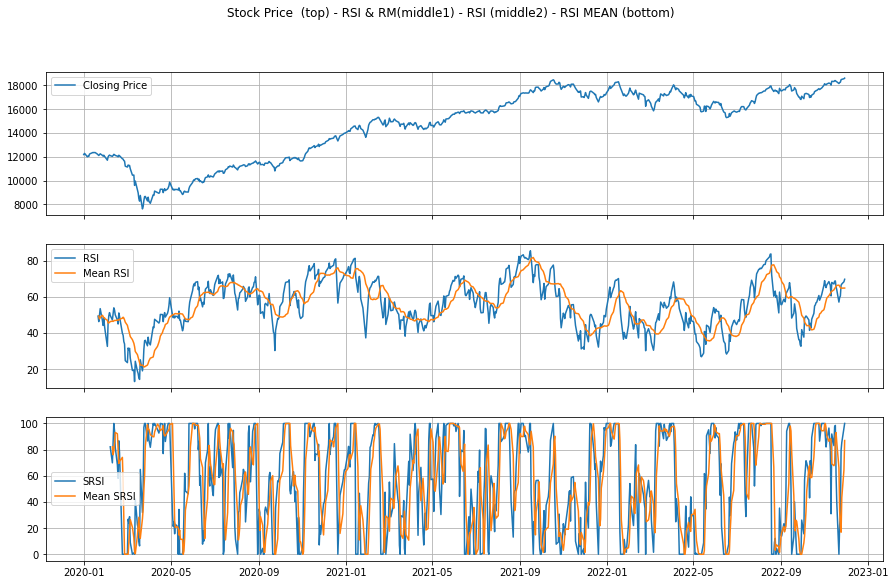

In [195]:
if __name__ == '__main__':
    dataset = download_data()
    print(dataset)

    dataset1=rsi(dataset)
    dataset1=srsi(dataset1)
    dataset1=returns(dataset1)
    show(dataset1)

# **Ichimoku Indicator**
In order to compare our strategy, we will use a famous well performing indicator called **Ichimoku**.
The indicator displays a collection of technical indicators that act as support and resistance levels.  
It also uses these figures to compute a "**cloud**" that can forecast the trend of the price.
### The indicator can be broken down into the following components:


> $$\text{Conversion Line (tenkan sen)} = \frac{\text{9-PH}+\text{9-PL}}{2}$$\
$$\text{Base Line (kijun sen)} = \frac{\text{26-PH}+\text{26-PL}}{2}$$\
$$\text{Leading Span A (senkou span A)} = \frac{\text{CL}+\text{Base Line}}{2}$$\
$$\text{Leading Span B (senkou span B)} = \frac{\text{52-PH}+\text{52-PL}}{2}$$\
$$\text{Lagging Span (chikou span)} = \text{Close plotted 26 periods in the past}$$\
**where:**  
$\text{PH}=\text{Period High}$\
$\text{PL}=\text{Period Low}$\
$\text{CL}=\text{Conversion Line}$

The difference between Leading Span A and Leading Span B is colored to create the cloud. The areas where the Span A is above is colored green indicating an uptrend while the other is colored red indicating a downtrend.  
The buying and selling signals are generated using the cloud and the **chikou-span**.


In [196]:
def download_data(stocks,start_date,end_date, interval='1d'):
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data['Close'] = ticker.history(start=start_date, end=end_date, interval=interval)['Close']
        stock_data['Open'] = ticker.history(start=start_date, end=end_date, interval=interval)['Open']
        stock_data['High'] = ticker.history(start=start_date, end=end_date, interval=interval)['High']
        stock_data['Low'] = ticker.history(start=start_date, end=end_date, interval=interval)['Low']
    return pd.DataFrame(stock_data)

# Downloading data for two years
start_date=dt.date.today() - dt.timedelta(days = 365*2)
end_date=dt.date.today()
df=download_data(['^NSEI'],start_date,end_date)

# **Calculating Ichimoku components**

In [197]:
# Calculating Tenkan-Sen, Kijun-Sen, Senkou-Span A
high_9 = df['High'].rolling(9).max()
low_9 = df['Low'].rolling(9).min()
df['Tenkan_Sen'] = (high_9 + low_9)/2

high_26 = df['High'].rolling(26).max()
low_26 = df['Low'].rolling(26).min()
df['Kijun_Sen'] = (high_26 + low_26) /2

df['Senkou_Span_A'] = ((df['Tenkan_Sen'] + df['Kijun_Sen']) / 2).shift(26)

# Calculating Senkou-Span B and Chikou-Span
high_52 = df['High'].rolling(52).max()
low_52 = df['Low'].rolling(52).min()
df['Senkou_Span_B'] = ((high_52 + low_52) /2).shift(26)

df['Chikou_Span']=df['Close'].shift(-26)
df

,Close,Open,High,Low,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span
Date,,,,,,,,,
2020-12-14 00:00:00+05:30,13558.150391,13571.450195,13597.500000,13472.450195,NaN,NaN,NaN,NaN,14644.700195
2020-12-15 00:00:00+05:30,13567.849609,13547.200195,13589.650391,13447.049805,NaN,NaN,NaN,NaN,14590.349609
2020-12-16 00:00:00+05:30,13682.700195,13663.099609,13692.349609,13606.450195,NaN,NaN,NaN,NaN,14371.900391
2020-12-17 00:00:00+05:30,13740.700195,13713.549805,13773.250000,13673.549805,NaN,NaN,NaN,NaN,14238.900391
2020-12-18 00:00:00+05:30,13760.549805,13764.400391,13772.849609,13658.599609,NaN,NaN,NaN,NaN,13967.500000
...,...,...,...,...,...,...,...,...,...
2022-12-07 00:00:00+05:30,18560.500000,18638.849609,18668.300781,18528.400391,18626.599609,18423.399414,17553.575195,17421.924805,NaN
2022-12-08 00:00:00+05:30,18609.349609,18570.849609,18625.000000,18536.949219,18626.599609,18423.399414,17630.075195,17461.750000,NaN
2022-12-09 00:00:00+05:30,18496.599609,18662.400391,18664.699219,18410.099609,18648.849609,18423.399414,17631.549805,17463.224609,NaN


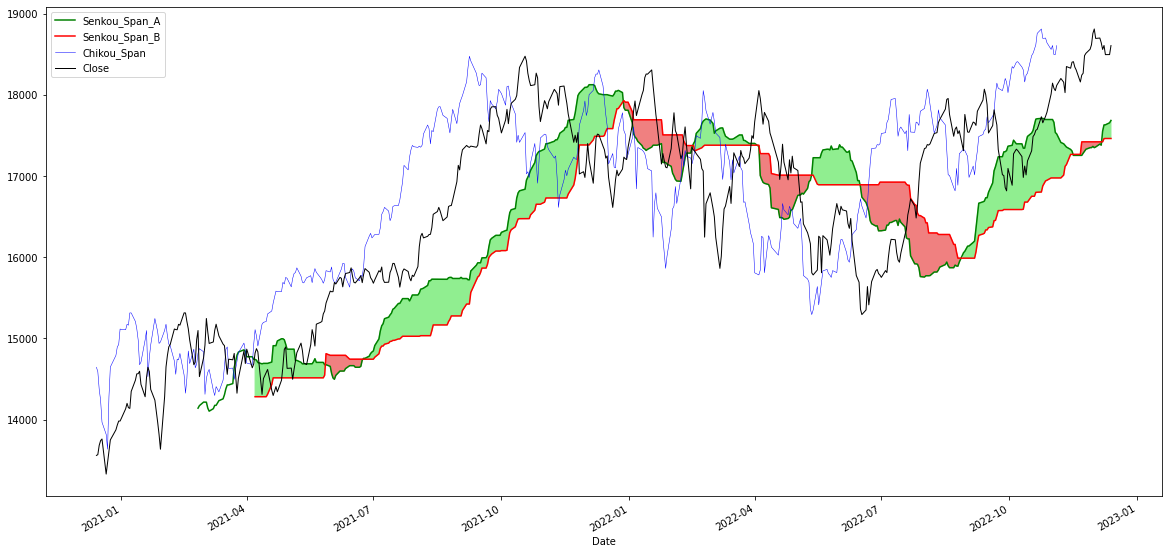

In [198]:
# Plotting the indicator
fig,ax = plt.subplots(1,1,sharex=True,figsize = (20,10))

df['Senkou_Span_A'].plot(ax=ax,color='green')
df['Senkou_Span_B'].plot(ax=ax,color='red')
df['Chikou_Span'].plot(ax=ax,color='blue',linewidth=0.5)

ax.plot(df.index, df.Close,linewidth=1,label='Close',color='black')
ax.legend();

ax.fill_between(df.index,df.Senkou_Span_A,df.Senkou_Span_B,where = df.Senkou_Span_A >= df.Senkou_Span_B, color = 'lightgreen')
ax.fill_between(df.index,df.Senkou_Span_A,df.Senkou_Span_B,where = df.Senkou_Span_A < df.Senkou_Span_B, color = 'lightcoral')
plt.show()

# **Calculating Returns**

In [199]:
# calculating Signal
df['Senkou_Signal']=((df['Senkou_Span_A']-df['Senkou_Span_B']).apply(np.sign)+1)/2
df['Chikou_Signal']=((df['Chikou_Span']-df['Close']).apply(np.sign)+1)/2
df['Buy']=df['Chikou_Signal']*df['Senkou_Signal']

#Cleaning Data
df.drop(['Open','High','Low','Tenkan_Sen','Kijun_Sen','Senkou_Span_A','Senkou_Span_B'],axis=1, inplace=True)
df.dropna(inplace=True)
print(df)

# Calculating Returns
trades=len(df[df['Buy']==1])
df['Return'] = (np.log(df['Close']/df['Close'].shift()))*(df['Buy'].shift(1))
returns = (np.exp(df[['Return']].mean()*252)-1)*100
print("Number of trades made:",trades)
print(f"Returns : {returns}%")
print("Standard Deviation: ",df['Return'].std()*(2*252)**0.5)

                                  Close   Chikou_Span  Senkou_Signal  \
Date                                                                   
2021-04-07 00:00:00+05:30  14819.049805  15108.099609            1.0   
2021-04-08 00:00:00+05:30  14873.799805  15030.150391            1.0   
2021-04-09 00:00:00+05:30  14834.849609  14906.049805            1.0   
2021-04-12 00:00:00+05:30  14310.799805  15175.299805            1.0   
2021-04-13 00:00:00+05:30  14504.799805  15197.700195            1.0   
...                                 ...           ...            ...   
2022-10-31 00:00:00+05:30  18012.199219  18560.500000            1.0   
2022-11-01 00:00:00+05:30  18145.400391  18609.349609            1.0   
2022-11-02 00:00:00+05:30  18082.849609  18496.599609            1.0   
2022-11-03 00:00:00+05:30  18052.699219  18497.150391            1.0   
2022-11-04 00:00:00+05:30  18117.150391  18608.000000            1.0   

                           Chikou_Signal  Buy  
Date           